In [1]:
!pip install imbalanced-learn
!pip install xgboost
!pip install lightgbm

import os
import joblib
import joblib, os
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.utils import resample
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.7/291.7 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 36.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
TRAIN_PATH = "/content/drive/My Drive/Machine Learning/2025/train"
TEST_PATH = "/content/drive/My Drive/Machine Learning/2025/test"

# Reading the parquet files in a folder
def read_parquet_files(folder_path):
    parquet_files = glob(os.path.join(folder_path, "*.parquet"))
    df_list = [pd.read_parquet(file) for file in parquet_files]
    return pd.concat(df_list, ignore_index=True)

# Loading data
df_train = read_parquet_files(TRAIN_PATH)
df_test = read_parquet_files(TEST_PATH)

print(f"Train Shape: {df_train.shape}")
print(f"Test Shape: {df_test.shape}")


Train Shape: (229624, 23)
Test Shape: (25514, 15)


In [4]:
# Checking null values
print("Null values in Train:")
print(df_train.isnull().sum())

# Blank values
print("\nBlank strings in Train:")
print((df_train == '').sum())

print("\nData Types:")
print(df_train.dtypes)


Null values in Train:
product_id              0
title                   0
description             0
tags                    0
type                    0
room                    0
craft_type              0
recipient               0
material                0
occasion                0
holiday                 0
art_subject             0
style                   0
shape                   0
pattern                 0
bottom_category_id      0
bottom_category_text    0
top_category_id         0
top_category_text       0
primary_color_id        0
primary_color_text      0
secondary_color_id      0
secondary_color_text    0
dtype: int64

Blank strings in Train:
product_id                   0
title                      810
description                810
tags                     31169
type                       348
room                    220686
craft_type              201862
recipient               218815
material                209384
occasion                171550
holiday                 183359
a

In [5]:
# Numerical Descriptive Statistics
print("\nNumerical Stats:")
print(df_train.describe())

# Categorical Description
print("\nCategorical Stats:")
print(df_train.describe(include=['object']))



Numerical Stats:
         product_id  bottom_category_id  top_category_id  primary_color_id  \
count  2.296240e+05       229624.000000    229624.000000     229624.000000   
mean   1.179276e+09         3505.658106         6.991643          8.614731   
std    3.840381e+08         3751.955565         3.605474          6.421168   
min    5.023404e+06            1.000000         0.000000          0.000000   
25%    8.878686e+08          969.000000         5.000000          2.000000   
50%    1.264325e+09         1793.000000         7.000000          9.000000   
75%    1.515061e+09         6336.000000         9.000000         14.000000   
max    1.669799e+09        12493.000000        14.000000         19.000000   

       secondary_color_id  
count       229624.000000  
mean             9.505753  
std              6.433769  
min              0.000000  
25%              2.000000  
50%             10.000000  
75%             16.000000  
max             19.000000  

Categorical Stats:
       

In [6]:
# Selecting numerical columns
numeric_cols = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Numerical columns:", numeric_cols)


Numerical columns: ['product_id', 'bottom_category_id', 'top_category_id', 'primary_color_id', 'secondary_color_id']


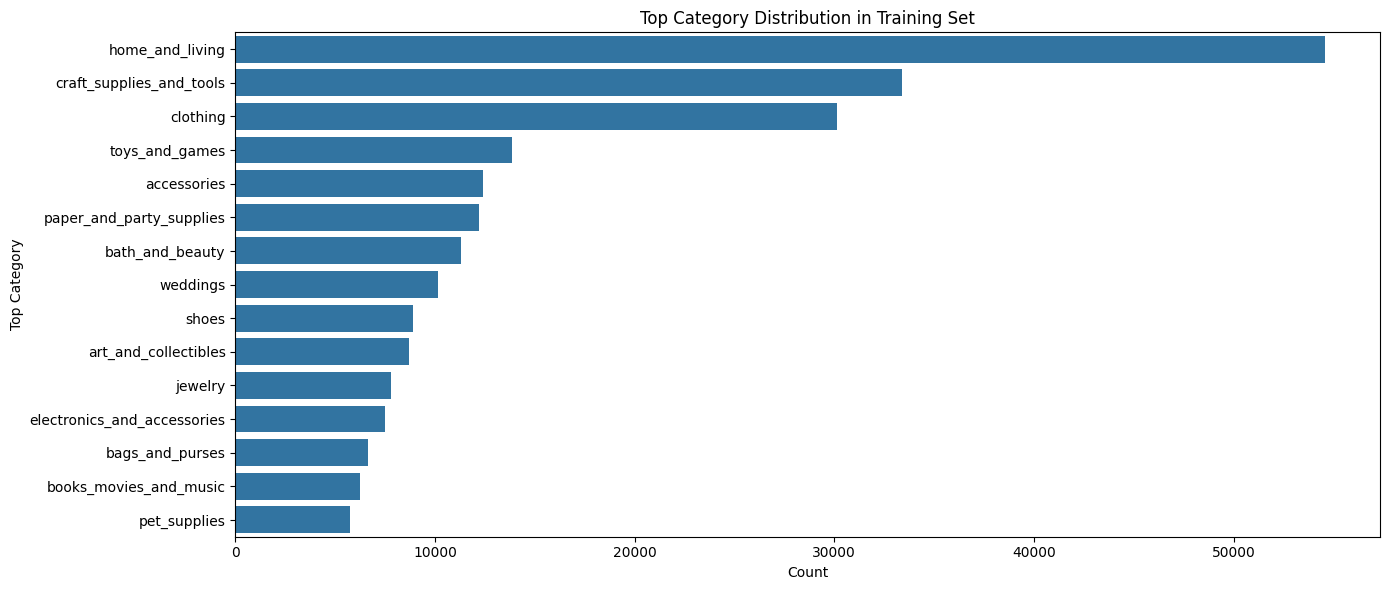

In [ ]:
# Bar Plot for Top Category Distribution
plt.figure(figsize=(14, 6))
sns.countplot(y=df_train['top_category_text'], order=df_train['top_category_text'].value_counts().index)
plt.title("Top Category Distribution in Training Set")
plt.xlabel("Count")
plt.ylabel("Top Category")
plt.tight_layout()
plt.show()


In [7]:
# Z-score filtering
z_scores = np.abs(zscore(df_train[numeric_cols].dropna()))
df_train_cleaned = df_train[(z_scores < 3).all(axis=1)]

print(f"Original shape: {df_train.shape}")
print(f"After removing outliers: {df_train_cleaned.shape}")


Original shape: (229624, 23)
After removing outliers: (229576, 23)


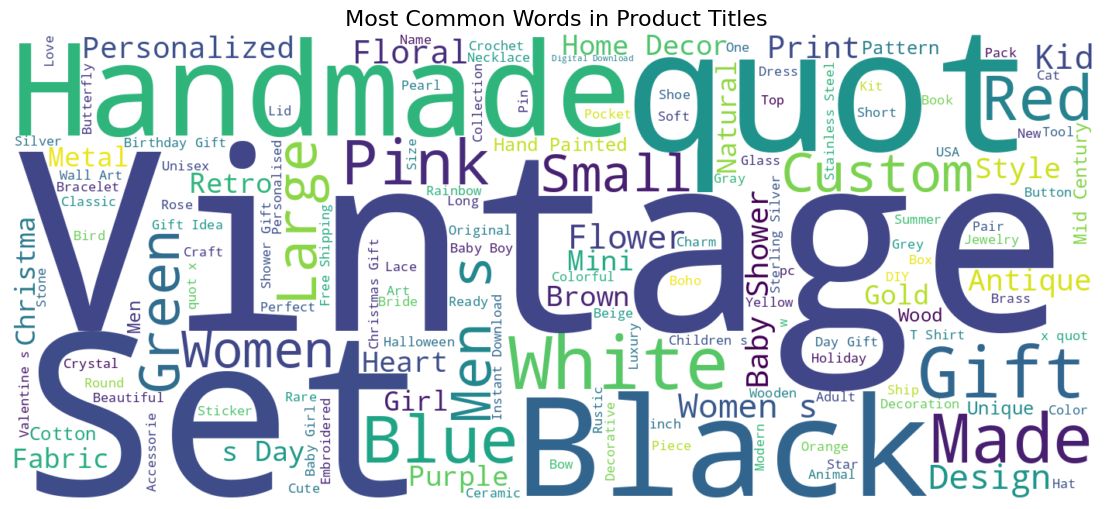

In [ ]:
from wordcloud import WordCloud
text_data = " ".join(df_train['title'].dropna().values)
wordcloud = WordCloud(width=1400, height=600, background_color='white', max_words=150).generate(text_data)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(" Most Common Words in Product Titles", fontsize=16)
plt.show()


In [8]:
# Checking for missing values
missing_values = df_train.isnull().sum()
missing_percent = (missing_values / len(df_train)) * 100

# Display only columns with missing data
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Missing %': missing_percent})
print(missing_df[missing_df['Missing Values'] > 0])


Empty DataFrame
Columns: [Missing Values, Missing %]
Index: []


In [9]:
# Filling missing text fields
text_columns = df_train.select_dtypes(include='object').columns
df_train[text_columns] = df_train[text_columns].fillna('')

# Filling numeric fields with median
numeric_columns = df_train.select_dtypes(include=['int64', 'float64']).columns
df_train[numeric_columns] = df_train[numeric_columns].fillna(df_train[numeric_columns].median())


In [10]:
# Recreate the split
df_train, df_val = train_test_split(
    df_train,
    test_size=0.1,
    stratify=df_train['top_category_text'],
    random_state=42
)


In [11]:
# Define input texts and labels for model tuning
train_texts = df_train['title'].values
val_texts = df_val['title'].values
train_labels = df_train['top_category_text'].values
val_labels = df_val['top_category_text'].values


In [12]:
# Identify text columns in each DataFrame individually
train_text_columns = df_train.select_dtypes(include='object').columns
val_text_columns = df_val.select_dtypes(include='object').columns
test_text_columns = df_test.select_dtypes(include='object').columns

# Filling missing values for columns that exist
df_train[train_text_columns] = df_train[train_text_columns].fillna('')
df_val[val_text_columns] = df_val[val_text_columns].fillna('')
df_test[test_text_columns] = df_test[test_text_columns].fillna('')


In [13]:
print("Any missing values left in train?", df_train.isnull().any().any())
print("Any missing values left in val?", df_val.isnull().any().any())
print("Any missing values left in test?", df_test.isnull().any().any())


Any missing values left in train? False
Any missing values left in val? False
Any missing values left in test? False


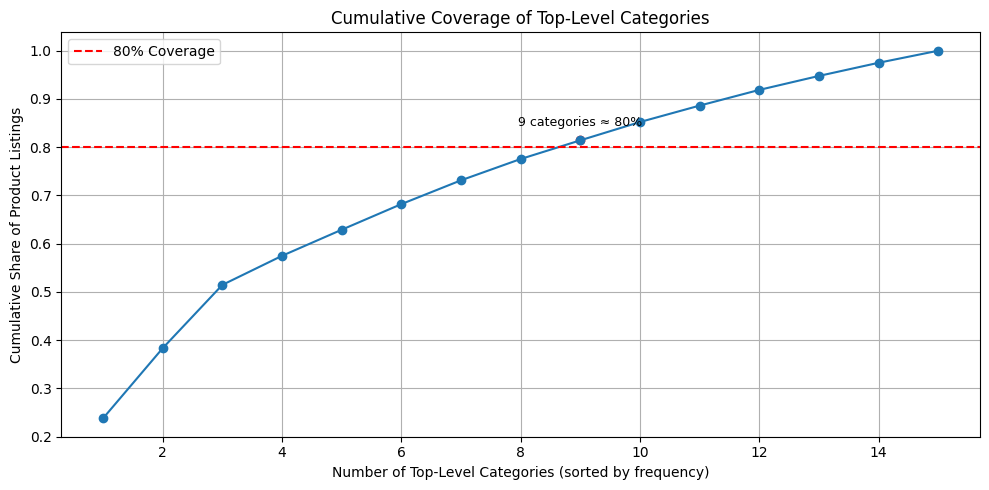

In [ ]:
import matplotlib.pyplot as plt

# Count and calculate cumulative distribution
category_counts = df_train['top_category_text'].value_counts()
cumulative = category_counts.cumsum() / category_counts.sum()

# X-axis represents the number of top categories included
x_values = range(1, len(cumulative) + 1)
y_values = cumulative.values

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x_values, y_values, marker='o')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Coverage')

# Find the point where cumulative crosses 80%
cutoff_idx = next(i for i, v in enumerate(y_values) if v >= 0.8)
plt.scatter(x_values[cutoff_idx], y_values[cutoff_idx], color='red')
plt.text(x_values[cutoff_idx], y_values[cutoff_idx] + 0.03,
         f"{x_values[cutoff_idx]} categories ≈ 80%", ha='center', fontsize=9)

# Labels and title
plt.title('Cumulative Coverage of Top-Level Categories')
plt.xlabel('Number of Top-Level Categories (sorted by frequency)')
plt.ylabel('Cumulative Share of Product Listings')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
# Encoding target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(df_train['top_category_text'])


In [15]:
joblib.dump(label_encoder, "/content/drive/MyDrive/Models/label_encoder.pkl")

['/content/drive/MyDrive/Models/label_encoder.pkl']

In [16]:
save_dir = "/content/drive/MyDrive/Models"
os.makedirs(save_dir, exist_ok=True)


# Vectorize product titles
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(df_train['title'].fillna(''))

# Save the fitted TF-IDF vectorizer
joblib.dump(tfidf, os.path.join(save_dir, "tfidf_vectorizer.pkl"))
print("TF-IDF vectorizer saved successfully.")

# Use SMOTE to balance the class distribution
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_tfidf, y_train_encoded)


TF-IDF vectorizer saved successfully.


In [17]:
X_val_tfidf = tfidf.transform(df_val['title'].fillna(''))
y_val_encoded = label_encoder.transform(df_val['top_category_text'])

joblib.dump(X_val_tfidf, "/content/drive/MyDrive/Models/X_val_tfidf.pkl")
joblib.dump(y_val_encoded, "/content/drive/MyDrive/Models/y_val_encoded.pkl")

['/content/drive/MyDrive/Models/y_val_encoded.pkl']

In [22]:
# Training on SMOTE-balanced data
clf = LogisticRegression(max_iter=200, class_weight='balanced')
clf.fit(X_resampled, y_resampled)

# Prediction on Validation Set
val_preds = clf.predict(X_val_tfidf)

# Report
print("Classification Report after SMOTE + Logistic Regression:")
print(classification_report(y_val_encoded, val_preds, target_names=label_encoder.classes_))
print(f"F1 Score (Weighted): {f1_score(y_val_encoded, val_preds, average='weighted'):.4f}")


Classification Report after SMOTE + Logistic Regression:
                             precision    recall  f1-score   support

                accessories       0.71      0.75      0.73      1242
       art_and_collectibles       0.44      0.62      0.51       872
            bags_and_purses       0.69      0.82      0.75       665
            bath_and_beauty       0.75      0.79      0.77      1133
     books_movies_and_music       0.69      0.85      0.76       626
                   clothing       0.94      0.90      0.92      3014
   craft_supplies_and_tools       0.83      0.72      0.77      3339
electronics_and_accessories       0.73      0.83      0.78       748
            home_and_living       0.88      0.76      0.82      5460
                    jewelry       0.70      0.83      0.76       782
   paper_and_party_supplies       0.74      0.79      0.76      1221
               pet_supplies       0.74      0.83      0.78       574
                      shoes       0.90      0

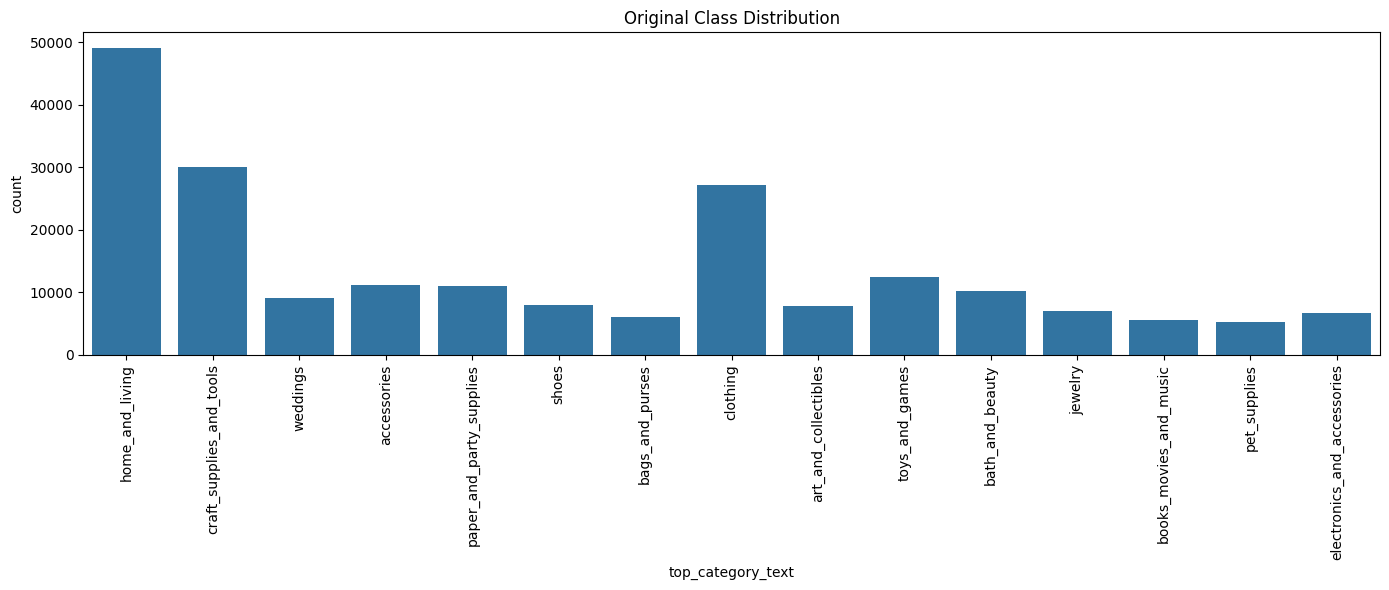

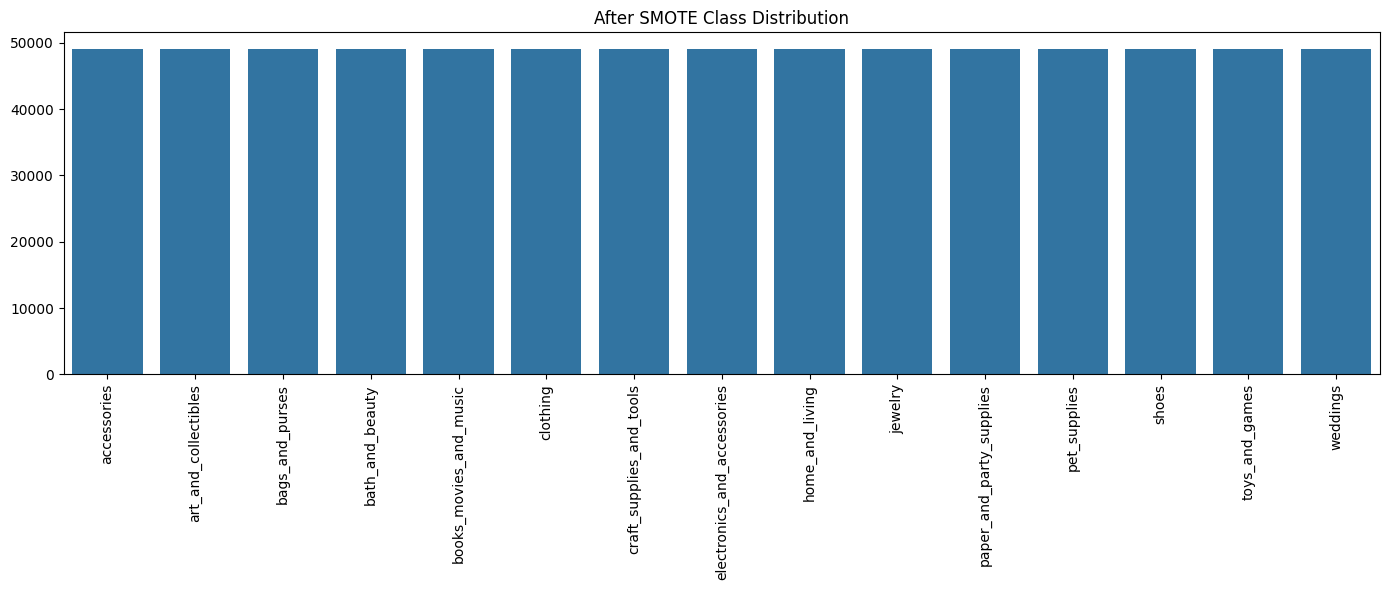

In [ ]:
#Before SMOTE
plt.figure(figsize=(14, 6))
sns.countplot(x=df_train['top_category_text'])
plt.title("Original Class Distribution")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# After SMOTE
unique, counts = np.unique(y_resampled, return_counts=True)
plt.figure(figsize=(14, 6))
sns.barplot(x=label_encoder.inverse_transform(unique), y=counts)
plt.title("After SMOTE Class Distribution")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [23]:
MODEL_DIR = "/content/drive/MyDrive/Models"
os.makedirs(MODEL_DIR, exist_ok=True)

# Initialize models
log_reg = LogisticRegression(max_iter=200, class_weight='balanced', random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Fit on oversampled data
log_reg.fit(X_resampled, y_resampled)
rf.fit(X_resampled, y_resampled)

joblib.dump(log_reg, os.path.join(MODEL_DIR, "log_reg_model.pkl"))
joblib.dump(rf, os.path.join(MODEL_DIR, "random_forest_model.pkl"))


# Predicting on validation dataset
preds_log = log_reg.predict(X_val_tfidf)
preds_rf = rf.predict(X_val_tfidf)


# Evaluation
print("Logistic Regression:\n", classification_report(y_val_encoded, preds_log))
print("Random Forest:\n", classification_report(y_val_encoded, preds_rf))



Logistic Regression:
               precision    recall  f1-score   support

           0       0.71      0.75      0.73      1242
           1       0.44      0.62      0.51       872
           2       0.69      0.82      0.75       665
           3       0.75      0.79      0.77      1133
           4       0.69      0.85      0.76       626
           5       0.94      0.90      0.92      3014
           6       0.83      0.72      0.77      3339
           7       0.73      0.83      0.78       748
           8       0.88      0.76      0.82      5460
           9       0.70      0.83      0.76       782
          10       0.74      0.79      0.76      1221
          11       0.74      0.83      0.78       574
          12       0.90      0.94      0.92       889
          13       0.72      0.75      0.73      1384
          14       0.61      0.61      0.61      1014

    accuracy                           0.78     22963
   macro avg       0.74      0.79      0.76     22963
weig

In [23]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(class_weight='balanced', random_state=42)
lgbm.fit(X_resampled, y_resampled)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 7.273348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 451666
[LightGBM] [Info] Number of data points in the train set: 737100, number of used features: 5000
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.7

LGBMClassifier(class_weight='balanced', random_state=42)

In [24]:
preds_lgbm = lgbm.predict(X_val_tfidf)

print(" LightGBM Evaluation:\n", classification_report(y_val_encoded, preds_lgbm, target_names=label_encoder.classes_))
print(f" F1 Score (Weighted): {f1_score(y_val_encoded, preds_lgbm, average='weighted'):.4f}")
joblib.dump(log_reg, os.path.join(MODEL_DIR, "lgbm_model.pkl"))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


 LightGBM Evaluation:
                              precision    recall  f1-score   support

                accessories       0.73      0.76      0.74      1242
       art_and_collectibles       0.39      0.63      0.48       872
            bags_and_purses       0.69      0.84      0.76       665
            bath_and_beauty       0.74      0.80      0.77      1133
     books_movies_and_music       0.67      0.84      0.75       626
                   clothing       0.93      0.90      0.91      3014
   craft_supplies_and_tools       0.82      0.70      0.75      3339
electronics_and_accessories       0.76      0.80      0.78       748
            home_and_living       0.84      0.74      0.79      5460
                    jewelry       0.70      0.86      0.77       782
   paper_and_party_supplies       0.73      0.77      0.75      1221
               pet_supplies       0.73      0.84      0.78       574
                      shoes       0.90      0.96      0.93       889
          

['/content/drive/MyDrive/Models/lgbm_model.pkl']

In [18]:
MODEL_DIR = "/content/drive/MyDrive/Models"

# Loading the saved models
log_reg = joblib.load(f"{MODEL_DIR}/log_reg_model.pkl")
rf = joblib.load(f"{MODEL_DIR}/random_forest_model.pkl")
lgbm = joblib.load(f"{MODEL_DIR}/lgbm_model.pkl")

# Loading vectorizer and label encoder
tfidf = joblib.load(f"{MODEL_DIR}/tfidf_vectorizer.pkl")
label_encoder = joblib.load(f"{MODEL_DIR}/label_encoder.pkl")

In [19]:
X_val_tfidf = joblib.load(f"{MODEL_DIR}/X_val_tfidf.pkl")
y_val_encoded = joblib.load(f"{MODEL_DIR}/y_val_encoded.pkl")



In [46]:
# Build and fit ensemble
ensemble = VotingClassifier(
    estimators=[
        ('lr', log_reg),
        ('rf', rf),
        ('lgbm', lgbm)
    ],
    voting='hard'
)
ensemble.fit(X_val_tfidf, y_val_encoded)

# Save the model to Drive
ensemble_path = os.path.join(MODEL_DIR, "ensemble_model.pkl")
joblib.dump(ensemble, ensemble_path)
print(f" Ensemble model saved successfully at: {ensemble_path}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 66046
[LightGBM] [Info] Number of data points in the train set: 22963, number of used features: 2242
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[Light

In [47]:
MODEL_DIR = "/content/drive/MyDrive/Models"
ensemble = joblib.load(f"{MODEL_DIR}/ensemble_model.pkl")

# Predictions
ensemble_preds = ensemble.predict(X_val_tfidf)

# Evaluating the performance
print(" Ensemble Classifier Evaluation")
print(classification_report(y_val_encoded, ensemble_preds))
print(f" F1 Score (Weighted): {f1_score(y_val_encoded, ensemble_preds, average='weighted'):.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


 Ensemble Classifier Evaluation
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1242
           1       0.73      0.97      0.83       872
           2       0.85      0.99      0.92       665
           3       0.85      0.96      0.90      1133
           4       0.84      0.99      0.91       626
           5       0.99      0.96      0.97      3014
           6       0.94      0.83      0.88      3339
           7       0.90      0.99      0.94       748
           8       0.94      0.83      0.89      5460
           9       0.91      0.99      0.95       782
          10       0.91      0.98      0.94      1221
          11       0.93      0.99      0.96       574
          12       0.99      0.99      0.99       889
          13       0.92      0.92      0.92      1384
          14       0.92      0.96      0.94      1014

    accuracy                           0.92     22963
   macro avg       0.90      0.95      0.92     

**Bottom Category**

In [31]:
save_dir = "/content/drive/MyDrive/Models"
os.makedirs(save_dir, exist_ok=True)

# Encoding bottom category labels
bottom_label_encoder = LabelEncoder()
y_train_bottom_encoded = bottom_label_encoder.fit_transform(df_train['bottom_category_text'])
y_val_bottom_encoded = bottom_label_encoder.transform(df_val['bottom_category_text'])

# Save the label encoder
joblib.dump(bottom_label_encoder, os.path.join(save_dir, "bottom_label_encoder.pkl"))
print(" Bottom category label encoder saved.")


 Bottom category label encoder saved.


In [ ]:
# Reuse TF-IDF vectorizer trained on top category titles
from sklearn.feature_extraction.text import TfidfVectorizer
X_train_bottom_tfidf = tfidf.transform(df_train['title'].fillna(''))
X_val_bottom_tfidf = tfidf.transform(df_val['title'].fillna(''))


In [ ]:
# Balance bottom category classes
smote_bottom = SMOTE(random_state=42)
X_resampled_bottom, y_resampled_bottom = smote_bottom.fit_resample(X_train_bottom_tfidf, y_train_bottom_encoded)

print(" SMOTE applied for bottom category. Resampled shape:", X_resampled_bottom.shape)


 SMOTE applied for bottom category. Resampled shape: (242637, 5000)


In [ ]:
# Convert TF-IDF matrix to DataFrame for downsampling
X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray())


In [ ]:
# Downsample to 8% for faster training
X_sampled, y_sampled = resample(
    X_train_tfidf_df, y_train_encoded,
    replace=False,
    n_samples=int(0.10 * X_train_tfidf_df.shape[0]),
    random_state=42
)

In [ ]:
# Train LightGBM model
lgb_model = LGBMClassifier(random_state=42)
lgb_model.fit(X_sampled, y_sampled)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.267040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 58938
[LightGBM] [Info] Number of data points in the train set: 20666, number of used features: 2046
[LightGBM] [Info] Start training from score -2.916948
[LightGBM] [Info] Start training from score -3.278234
[LightGBM] [Info] Start training from score -3.534328
[LightGBM] [Info] Start training from score -3.016561
[LightGBM] [Info] Start training from score -3.665257
[LightGBM] [Info] Start training from score -2.031910
[LightGBM] [Info] Start training from score -1.915975
[LightGBM] [Info] Start training from score -3.447040
[LightGBM] [Info] Start training from score -1.431732
[LightGBM] [Info] Start training from score -3.383737
[LightGBM] [Info] Start training from score -2.911596
[LightGBM] [Info] Start training from score -3.637

LGBMClassifier(random_state=42)

In [ ]:
# Save model to drive
MODEL_DIR = "/content/drive/MyDrive/Models"
lgb_path = os.path.join(MODEL_DIR, "bottom_lgb_model.pkl")
joblib.dump(lgb_model, lgb_path)
print(f" LightGBM model for bottom category saved at: {lgb_path}")


 LightGBM model for bottom category saved at: /content/drive/MyDrive/Etsy Models/bottom_lgb_model.pkl


In [ ]:
# Evaluate on validation set
val_preds_lgb = lgb_model.predict(X_val_tfidf)
print("\n LightGBM Bottom Category Evaluation:")
print(classification_report(y_val_encoded, val_preds_lgb))
print(f" F1 Score (Weighted): {f1_score(y_val_encoded, val_preds_lgb, average='weighted'):.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 LightGBM Bottom Category Evaluation:
              precision    recall  f1-score   support

           0       0.69      0.61      0.65      1242
           1       0.54      0.29      0.38       872
           2       0.71      0.67      0.69       665
           3       0.72      0.64      0.68      1133
           4       0.72      0.50      0.59       626
           5       0.87      0.90      0.89      3014
           6       0.68      0.66      0.67      3339
           7       0.77      0.61      0.68       748
           8       0.64      0.85      0.73      5460
           9       0.74      0.72      0.73       782
          10       0.72      0.69      0.70      1221
          11       0.80      0.71      0.75       574
          12       0.89      0.87      0.88       889
          13       0.71      0.51      0.59      1384
          14       0.62      0.48      0.54      1014

    accuracy                           0.71     22963
   macro avg       0.72      0.65      0.

In [30]:
# Ridge Classifier for Bottom Category (High-dimensional text model)
ridge_bottom = RidgeClassifier(class_weight='balanced')
ridge_bottom.fit(X_train_tfidf, y_train_encoded)

RidgeClassifier(class_weight='balanced')

In [ ]:
# Predict and evaluate
val_preds_ridge = ridge_bottom.predict(X_val_tfidf)
print("\n[Ridge Classifier] Classification Report (Bottom Category):")
print(classification_report(y_val_encoded, val_preds_ridge))
print(f"F1 Score (Weighted): {f1_score(y_val_encoded, val_preds_ridge, average='weighted'):.4f}")


[Ridge Classifier] Classification Report (Bottom Category):
              precision    recall  f1-score   support

           0       0.67      0.75      0.71      1242
           1       0.40      0.64      0.50       872
           2       0.64      0.85      0.73       665
           3       0.70      0.81      0.75      1133
           4       0.61      0.83      0.70       626
           5       0.93      0.90      0.92      3014
           6       0.83      0.67      0.74      3339
           7       0.69      0.85      0.76       748
           8       0.90      0.68      0.77      5460
           9       0.65      0.86      0.74       782
          10       0.66      0.80      0.73      1221
          11       0.68      0.86      0.76       574
          12       0.86      0.95      0.90       889
          13       0.73      0.70      0.72      1384
          14       0.61      0.55      0.58      1014

    accuracy                           0.75     22963
   macro avg       

In [ ]:
df_predictions = df_test.copy()

top_preds_encoded = ensemble_top.predict(X_test_tfidf)
bottom_preds_encoded = ridge_bottom.predict(X_test_bottom_tfidf)

# Converting encoded predictions back to labels
top_preds_labels = label_encoder.inverse_transform(top_preds_encoded)
bottom_preds_labels = bottom_label_encoder.inverse_transform(bottom_preds_encoded)

df_predictions["top_category_id"] = top_preds_labels
df_predictions["bottom_category_id"] = bottom_preds_labels

# Select required columns
student_id = "11866"  # Replace with your actual student ID if needed
parquet_path = f"predictions_{student_id}.parquet"

# Save to Parquet
df_predictions[["product_id", "top_category_id", "bottom_category_id"]].to_parquet(parquet_path, index=False)
print(f"Parquet file saved: {parquet_path}")

In [48]:
MODEL_DIR = "/content/drive/MyDrive/Models"
tfidf = joblib.load(f"{MODEL_DIR}/tfidf_vectorizer.pkl")
top_label_encoder = joblib.load(f"{MODEL_DIR}/label_encoder.pkl")
bottom_label_encoder = joblib.load(f"{MODEL_DIR}/bottom_label_encoder.pkl")
ensemble_top = joblib.load(f"{MODEL_DIR}/ensemble_model.pkl")
ridge_bottom = joblib.load(f"{MODEL_DIR}/ridge_bottom_category.pkl")

In [49]:
tfidf = joblib.load("/content/drive/MyDrive/Models/tfidf_vectorizer.pkl")

X_test_tfidf = tfidf.transform(df_test["title"].fillna(''))

In [50]:
top_preds = ensemble_top.predict(X_test_tfidf)
bottom_preds = ridge_bottom.predict(X_test_tfidf)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [51]:
top_preds_encoded = ensemble_top.predict(X_test_tfidf)
bottom_preds_encoded = ridge_bottom.predict(X_test_tfidf)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [52]:
top_preds_labels = label_encoder.inverse_transform(top_preds_encoded)
bottom_preds_labels = bottom_label_encoder.inverse_transform(bottom_preds_encoded)

df_predictions = df_test.copy()
df_predictions["top_category_id"] = top_preds_labels
df_predictions["bottom_category_id"] = bottom_preds_labels

In [54]:
student_id = "11866"
parquet_path = f"predictions_{student_id}.parquet"

# Save to Parquet
df_predictions[["product_id", "top_category_id", "bottom_category_id"]].to_parquet(parquet_path, index=False)
print(f"Parquet file saved: {parquet_path}")

Parquet file saved: predictions_11866.parquet
